In [3]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

# CNN

## Densenet


##  Flower Data

In [11]:
###-----------------
### Import Libraries
###-----------------

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score, classification_report
import tensorflow as tf

from utils.helper import fn_plot_tf_hist,fn_plot_confusion_matrix

In [13]:
###----------------------
### Some basic parameters
###----------------------
inpDir = '../..\Classwork/input'
outDir = './output'
subDir = 'flower_photos'
modelDir = './models'
logDir = './logs'
altName = 'cnn_base'

RANDOM_STATE = 24 # for initialization ----- REMEMBER: to remove at the time of promotion to production
tf.random.set_seed(RANDOM_STATE) # setting for Tensorflow as well

TEST_SIZE = 0.2

ALPHA = 0.001
EPOCHS = 10 # number of cycles to run
FLIP_MODE = 'horizontal_and_vertical'
ROTATION = (-0.1,0.1)
BATCH_SIZE = 8 # inline of Training Rows being 60000
IMG_HEIGHT = 200
IMG_WIDTH = 200


# Set parameters for decoration of plots
params = {'legend.fontsize' : 'medium',
          'figure.figsize'  : (15,10),
          'axes.labelsize'  : 'medium',
          'axes.titlesize'  :'large',
          'xtick.labelsize' :'medium',
          'ytick.labelsize' :'medium',
         }

CMAP = plt.cm.coolwarm

plt.rcParams.update(params) # update rcParams

plt.style.use('seaborn-v0_8-darkgrid') # plt.style.use('ggplot')

## Basic Hygiene

In [14]:
physical_devices = tf.config.list_physical_devices('GPU')

if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [15]:
print (physical_devices)

[]


## Import data

In [16]:
'''
import pathlib
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"

data_dir = tf.keras.utils.get_file(origin=dataset_url,
                                   fname='flower_photos',
                                   untar=True)
data_dir = pathlib.Path(data_dir)

'''
data_dir = os.path.join(inpDir, subDir)
data_dir


'../..\\Classwork/input\\flower_photos'

In [17]:
os.listdir(data_dir)

['daisy', 'dandelion', 'LICENSE.txt', 'roses', 'sunflowers', 'tulips']

## Creating datasets

In [18]:
# create training data
train_ds =tf.keras.preprocessing.image_dataset_from_directory(
    data_dir, # path the the data directory
    validation_split=TEST_SIZE, # what ratio of validation data
    subset='training', # purpose
    seed=RANDOM_STATE,
    image_size=[IMG_HEIGHT, IMG_WIDTH], ## @@@ WHAT!
    batch_size=BATCH_SIZE
)
# test data
test_ds =tf.keras.preprocessing.image_dataset_from_directory(
    data_dir, # path the the data directory
    validation_split=TEST_SIZE, # what ratio of validation data
    subset='validation', # purpose
    seed=RANDOM_STATE,
    image_size=[IMG_HEIGHT, IMG_WIDTH], ## @@@ WHAT!
    batch_size=BATCH_SIZE
)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.
Found 3670 files belonging to 5 classes.
Using 734 files for validation.


In [19]:
# is it picking class names
class_names = train_ds.class_names
class_names

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']

In [20]:
class_dict = {k:v for k,v in enumerate(class_names)}
class_dict

{0: 'daisy', 1: 'dandelion', 2: 'roses', 3: 'sunflowers', 4: 'tulips'}

## Visualize data in train_ds and test_ds

In [ ]:
plt.figure(figsize=(15,8))

for images, labels in train_ds.take(1):
    for i in range (BATCH_SIZE):
        plt.subplot(int(BATCH_SIZE/8), 8, i +1)
        plt.grid(False)
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.title(class_names[labels[i]])
        plt.axis('off')
    plt.tight_layout()
plt.show()

In [ ]:
plt.figure(figsize=(15,8))

for images, labels in test_ds.take(1): # get me one batch

    for i in range (BATCH_SIZE): # loop over batch

        plt.subplot(int(BATCH_SIZE/8), 8, i +1) # access the axis

        plt.grid(False) # no to grid

        plt.imshow(images[i].numpy().astype('uint8')) # show image convert to numpy and int

        plt.title(class_names[labels[i]])

        plt.axis('off')

    plt.tight_layout()

plt.show()

## To check whether data is balanced or not

In [ ]:
def fn_plot_label(tr_ds, ts_ds):

    plt.figure(figsize = (15,5)) # instantiate the figure

    plt.subplot(1,2,1) # first out of 2

    train_labels = tf.concat([lbl for img, lbl in tr_ds], axis = 0).numpy() # get the labels

    unique, _, counts = tf.unique_with_counts(train_labels) # get counts

    plt.bar(range(len(unique)), counts, align='center', color = 'DarkBlue') # barplot the counts

    plt.xticks(range(len(unique)), class_names)

    plt.title('Training Set')

    plt.subplot(1,2,2)

    test_labels = tf.concat([lbl for img, lbl in ts_ds], axis = 0).numpy()

    unique, _, counts = tf.unique_with_counts(test_labels)

    plt.bar(range(len(unique)), counts, align='center', color = 'Orange')

    plt.xticks(range(len(unique)), class_names)

    plt.title('Test Set')


In [ ]:
fn_plot_label(train_ds, test_ds)

## Model Building

In [21]:
input_shape = (IMG_HEIGHT, IMG_WIDTH, 3)
num_classes = len(class_names)
input_shape, num_classes

((200, 200, 3), 5)

In [22]:
densenet_model = tf.keras.applications.DenseNet169(weights='imagenet',
                                                 include_top = False,
                                                  input_shape = input_shape)

densenet_model.summary()



Model: "densenet169"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 200, 200, 3)]        0         []                            
                                                                                                  
 zero_padding2d (ZeroPaddin  (None, 206, 206, 3)          0         ['input_1[0][0]']             
 g2D)                                                                                             
                                                                                                  
 conv1/conv (Conv2D)         (None, 100, 100, 64)         9408      ['zero_padding2d[0][0]']      
                                                                                                  
 conv1/bn (BatchNormalizati  (None, 100, 100, 64)         256       ['conv1/conv[0][0]

 D)                                                                                               
                                                                                                  
 conv2_block3_concat (Conca  (None, 50, 50, 160)          0         ['conv2_block2_concat[0][0]', 
 tenate)                                                             'conv2_block3_2_conv[0][0]'] 
                                                                                                  
 conv2_block4_0_bn (BatchNo  (None, 50, 50, 160)          640       ['conv2_block3_concat[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv2_block4_0_relu (Activ  (None, 50, 50, 160)          0         ['conv2_block4_0_bn[0][0]']   
 ation)                                                                                           
          

                                                                                                  
 conv3_block1_1_conv (Conv2  (None, 25, 25, 128)          16384     ['conv3_block1_0_relu[0][0]'] 
 D)                                                                                               
                                                                                                  
 conv3_block1_1_bn (BatchNo  (None, 25, 25, 128)          512       ['conv3_block1_1_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv3_block1_1_relu (Activ  (None, 25, 25, 128)          0         ['conv3_block1_1_bn[0][0]']   
 ation)                                                                                           
                                                                                                  
 conv3_blo

 ation)                                                                                           
                                                                                                  
 conv3_block5_1_conv (Conv2  (None, 25, 25, 128)          32768     ['conv3_block5_0_relu[0][0]'] 
 D)                                                                                               
                                                                                                  
 conv3_block5_1_bn (BatchNo  (None, 25, 25, 128)          512       ['conv3_block5_1_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv3_block5_1_relu (Activ  (None, 25, 25, 128)          0         ['conv3_block5_1_bn[0][0]']   
 ation)                                                                                           
          

 conv3_block9_0_relu (Activ  (None, 25, 25, 384)          0         ['conv3_block9_0_bn[0][0]']   
 ation)                                                                                           
                                                                                                  
 conv3_block9_1_conv (Conv2  (None, 25, 25, 128)          49152     ['conv3_block9_0_relu[0][0]'] 
 D)                                                                                               
                                                                                                  
 conv3_block9_1_bn (BatchNo  (None, 25, 25, 128)          512       ['conv3_block9_1_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv3_block9_1_relu (Activ  (None, 25, 25, 128)          0         ['conv3_block9_1_bn[0][0]']   
 ation)   

                                                                                                  
 pool3_relu (Activation)     (None, 25, 25, 512)          0         ['pool3_bn[0][0]']            
                                                                                                  
 pool3_conv (Conv2D)         (None, 25, 25, 256)          131072    ['pool3_relu[0][0]']          
                                                                                                  
 pool3_pool (AveragePooling  (None, 12, 12, 256)          0         ['pool3_conv[0][0]']          
 2D)                                                                                              
                                                                                                  
 conv4_block1_0_bn (BatchNo  (None, 12, 12, 256)          1024      ['pool3_pool[0][0]']          
 rmalization)                                                                                     
          

 conv4_block4_1_relu (Activ  (None, 12, 12, 128)          0         ['conv4_block4_1_bn[0][0]']   
 ation)                                                                                           
                                                                                                  
 conv4_block4_2_conv (Conv2  (None, 12, 12, 32)           36864     ['conv4_block4_1_relu[0][0]'] 
 D)                                                                                               
                                                                                                  
 conv4_block4_concat (Conca  (None, 12, 12, 384)          0         ['conv4_block3_concat[0][0]', 
 tenate)                                                             'conv4_block4_2_conv[0][0]'] 
                                                                                                  
 conv4_block5_0_bn (BatchNo  (None, 12, 12, 384)          1536      ['conv4_block4_concat[0][0]'] 
 rmalizati

                                                                                                  
 conv4_block8_1_relu (Activ  (None, 12, 12, 128)          0         ['conv4_block8_1_bn[0][0]']   
 ation)                                                                                           
                                                                                                  
 conv4_block8_2_conv (Conv2  (None, 12, 12, 32)           36864     ['conv4_block8_1_relu[0][0]'] 
 D)                                                                                               
                                                                                                  
 conv4_block8_concat (Conca  (None, 12, 12, 512)          0         ['conv4_block7_concat[0][0]', 
 tenate)                                                             'conv4_block8_2_conv[0][0]'] 
                                                                                                  
 conv4_blo

 ormalization)                                                                                    
                                                                                                  
 conv4_block12_1_relu (Acti  (None, 12, 12, 128)          0         ['conv4_block12_1_bn[0][0]']  
 vation)                                                                                          
                                                                                                  
 conv4_block12_2_conv (Conv  (None, 12, 12, 32)           36864     ['conv4_block12_1_relu[0][0]']
 2D)                                                                                              
                                                                                                  
 conv4_block12_concat (Conc  (None, 12, 12, 640)          0         ['conv4_block11_concat[0][0]',
 atenate)                                                            'conv4_block12_2_conv[0][0]']
          

 conv4_block16_1_bn (BatchN  (None, 12, 12, 128)          512       ['conv4_block16_1_conv[0][0]']
 ormalization)                                                                                    
                                                                                                  
 conv4_block16_1_relu (Acti  (None, 12, 12, 128)          0         ['conv4_block16_1_bn[0][0]']  
 vation)                                                                                          
                                                                                                  
 conv4_block16_2_conv (Conv  (None, 12, 12, 32)           36864     ['conv4_block16_1_relu[0][0]']
 2D)                                                                                              
                                                                                                  
 conv4_block16_concat (Conc  (None, 12, 12, 768)          0         ['conv4_block15_concat[0][0]',
 atenate) 

                                                                                                  
 conv4_block20_1_bn (BatchN  (None, 12, 12, 128)          512       ['conv4_block20_1_conv[0][0]']
 ormalization)                                                                                    
                                                                                                  
 conv4_block20_1_relu (Acti  (None, 12, 12, 128)          0         ['conv4_block20_1_bn[0][0]']  
 vation)                                                                                          
                                                                                                  
 conv4_block20_2_conv (Conv  (None, 12, 12, 32)           36864     ['conv4_block20_1_relu[0][0]']
 2D)                                                                                              
                                                                                                  
 conv4_blo

 2D)                                                                                              
                                                                                                  
 conv4_block24_1_bn (BatchN  (None, 12, 12, 128)          512       ['conv4_block24_1_conv[0][0]']
 ormalization)                                                                                    
                                                                                                  
 conv4_block24_1_relu (Acti  (None, 12, 12, 128)          0         ['conv4_block24_1_bn[0][0]']  
 vation)                                                                                          
                                                                                                  
 conv4_block24_2_conv (Conv  (None, 12, 12, 32)           36864     ['conv4_block24_1_relu[0][0]']
 2D)                                                                                              
          

 conv4_block28_1_conv (Conv  (None, 12, 12, 128)          143360    ['conv4_block28_0_relu[0][0]']
 2D)                                                                                              
                                                                                                  
 conv4_block28_1_bn (BatchN  (None, 12, 12, 128)          512       ['conv4_block28_1_conv[0][0]']
 ormalization)                                                                                    
                                                                                                  
 conv4_block28_1_relu (Acti  (None, 12, 12, 128)          0         ['conv4_block28_1_bn[0][0]']  
 vation)                                                                                          
                                                                                                  
 conv4_block28_2_conv (Conv  (None, 12, 12, 32)           36864     ['conv4_block28_1_relu[0][0]']
 2D)      

                                                                                                  
 conv4_block32_1_conv (Conv  (None, 12, 12, 128)          159744    ['conv4_block32_0_relu[0][0]']
 2D)                                                                                              
                                                                                                  
 conv4_block32_1_bn (BatchN  (None, 12, 12, 128)          512       ['conv4_block32_1_conv[0][0]']
 ormalization)                                                                                    
                                                                                                  
 conv4_block32_1_relu (Acti  (None, 12, 12, 128)          0         ['conv4_block32_1_bn[0][0]']  
 vation)                                                                                          
                                                                                                  
 conv4_blo

 conv5_block3_2_conv (Conv2  (None, 6, 6, 32)             36864     ['conv5_block3_1_relu[0][0]'] 
 D)                                                                                               
                                                                                                  
 conv5_block3_concat (Conca  (None, 6, 6, 736)            0         ['conv5_block2_concat[0][0]', 
 tenate)                                                             'conv5_block3_2_conv[0][0]'] 
                                                                                                  
 conv5_block4_0_bn (BatchNo  (None, 6, 6, 736)            2944      ['conv5_block3_concat[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv5_block4_0_relu (Activ  (None, 6, 6, 736)            0         ['conv5_block4_0_bn[0][0]']   
 ation)   

                                                                                                  
 conv5_block7_2_conv (Conv2  (None, 6, 6, 32)             36864     ['conv5_block7_1_relu[0][0]'] 
 D)                                                                                               
                                                                                                  
 conv5_block7_concat (Conca  (None, 6, 6, 864)            0         ['conv5_block6_concat[0][0]', 
 tenate)                                                             'conv5_block7_2_conv[0][0]'] 
                                                                                                  
 conv5_block8_0_bn (BatchNo  (None, 6, 6, 864)            3456      ['conv5_block7_concat[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv5_blo

 vation)                                                                                          
                                                                                                  
 conv5_block11_2_conv (Conv  (None, 6, 6, 32)             36864     ['conv5_block11_1_relu[0][0]']
 2D)                                                                                              
                                                                                                  
 conv5_block11_concat (Conc  (None, 6, 6, 992)            0         ['conv5_block10_concat[0][0]',
 atenate)                                                            'conv5_block11_2_conv[0][0]']
                                                                                                  
 conv5_block12_0_bn (BatchN  (None, 6, 6, 992)            3968      ['conv5_block11_concat[0][0]']
 ormalization)                                                                                    
          

 conv5_block15_1_relu (Acti  (None, 6, 6, 128)            0         ['conv5_block15_1_bn[0][0]']  
 vation)                                                                                          
                                                                                                  
 conv5_block15_2_conv (Conv  (None, 6, 6, 32)             36864     ['conv5_block15_1_relu[0][0]']
 2D)                                                                                              
                                                                                                  
 conv5_block15_concat (Conc  (None, 6, 6, 1120)           0         ['conv5_block14_concat[0][0]',
 atenate)                                                            'conv5_block15_2_conv[0][0]']
                                                                                                  
 conv5_block16_0_bn (BatchN  (None, 6, 6, 1120)           4480      ['conv5_block15_concat[0][0]']
 ormalizat

                                                                                                  
 conv5_block19_1_relu (Acti  (None, 6, 6, 128)            0         ['conv5_block19_1_bn[0][0]']  
 vation)                                                                                          
                                                                                                  
 conv5_block19_2_conv (Conv  (None, 6, 6, 32)             36864     ['conv5_block19_1_relu[0][0]']
 2D)                                                                                              
                                                                                                  
 conv5_block19_concat (Conc  (None, 6, 6, 1248)           0         ['conv5_block18_concat[0][0]',
 atenate)                                                            'conv5_block19_2_conv[0][0]']
                                                                                                  
 conv5_blo

 ormalization)                                                                                    
                                                                                                  
 conv5_block23_1_relu (Acti  (None, 6, 6, 128)            0         ['conv5_block23_1_bn[0][0]']  
 vation)                                                                                          
                                                                                                  
 conv5_block23_2_conv (Conv  (None, 6, 6, 32)             36864     ['conv5_block23_1_relu[0][0]']
 2D)                                                                                              
                                                                                                  
 conv5_block23_concat (Conc  (None, 6, 6, 1376)           0         ['conv5_block22_concat[0][0]',
 atenate)                                                            'conv5_block23_2_conv[0][0]']
          

 conv5_block27_1_bn (BatchN  (None, 6, 6, 128)            512       ['conv5_block27_1_conv[0][0]']
 ormalization)                                                                                    
                                                                                                  
 conv5_block27_1_relu (Acti  (None, 6, 6, 128)            0         ['conv5_block27_1_bn[0][0]']  
 vation)                                                                                          
                                                                                                  
 conv5_block27_2_conv (Conv  (None, 6, 6, 32)             36864     ['conv5_block27_1_relu[0][0]']
 2D)                                                                                              
                                                                                                  
 conv5_block27_concat (Conc  (None, 6, 6, 1504)           0         ['conv5_block26_concat[0][0]',
 atenate) 

                                                                                                  
 conv5_block31_1_bn (BatchN  (None, 6, 6, 128)            512       ['conv5_block31_1_conv[0][0]']
 ormalization)                                                                                    
                                                                                                  
 conv5_block31_1_relu (Acti  (None, 6, 6, 128)            0         ['conv5_block31_1_bn[0][0]']  
 vation)                                                                                          
                                                                                                  
 conv5_block31_2_conv (Conv  (None, 6, 6, 32)             36864     ['conv5_block31_1_relu[0][0]']
 2D)                                                                                              
                                                                                                  
 conv5_blo

In [23]:
for layer in densenet_model.layers:
    layer.trainable = False
    
densenet_model.summary()

Model: "densenet169"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 200, 200, 3)]        0         []                            
                                                                                                  
 zero_padding2d (ZeroPaddin  (None, 206, 206, 3)          0         ['input_1[0][0]']             
 g2D)                                                                                             
                                                                                                  
 conv1/conv (Conv2D)         (None, 100, 100, 64)         9408      ['zero_padding2d[0][0]']      
                                                                                                  
 conv1/bn (BatchNormalizati  (None, 100, 100, 64)         256       ['conv1/conv[0][0]']

 conv2_block4_0_bn (BatchNo  (None, 50, 50, 160)          640       ['conv2_block3_concat[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv2_block4_0_relu (Activ  (None, 50, 50, 160)          0         ['conv2_block4_0_bn[0][0]']   
 ation)                                                                                           
                                                                                                  
 conv2_block4_1_conv (Conv2  (None, 50, 50, 128)          20480     ['conv2_block4_0_relu[0][0]'] 
 D)                                                                                               
                                                                                                  
 conv2_block4_1_bn (BatchNo  (None, 50, 50, 128)          512       ['conv2_block4_1_conv[0][0]'] 
 rmalizati

 rmalization)                                                                                     
                                                                                                  
 conv3_block1_1_relu (Activ  (None, 25, 25, 128)          0         ['conv3_block1_1_bn[0][0]']   
 ation)                                                                                           
                                                                                                  
 conv3_block1_2_conv (Conv2  (None, 25, 25, 32)           36864     ['conv3_block1_1_relu[0][0]'] 
 D)                                                                                               
                                                                                                  
 conv3_block1_concat (Conca  (None, 25, 25, 160)          0         ['pool2_pool[0][0]',          
 tenate)                                                             'conv3_block1_2_conv[0][0]'] 
          

 conv3_block5_1_bn (BatchNo  (None, 25, 25, 128)          512       ['conv3_block5_1_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv3_block5_1_relu (Activ  (None, 25, 25, 128)          0         ['conv3_block5_1_bn[0][0]']   
 ation)                                                                                           
                                                                                                  
 conv3_block5_2_conv (Conv2  (None, 25, 25, 32)           36864     ['conv3_block5_1_relu[0][0]'] 
 D)                                                                                               
                                                                                                  
 conv3_block5_concat (Conca  (None, 25, 25, 288)          0         ['conv3_block4_concat[0][0]', 
 tenate)  

                                                                                                  
 conv3_block9_1_bn (BatchNo  (None, 25, 25, 128)          512       ['conv3_block9_1_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv3_block9_1_relu (Activ  (None, 25, 25, 128)          0         ['conv3_block9_1_bn[0][0]']   
 ation)                                                                                           
                                                                                                  
 conv3_block9_2_conv (Conv2  (None, 25, 25, 32)           36864     ['conv3_block9_1_relu[0][0]'] 
 D)                                                                                               
                                                                                                  
 conv3_blo

 pool3_pool (AveragePooling  (None, 12, 12, 256)          0         ['pool3_conv[0][0]']          
 2D)                                                                                              
                                                                                                  
 conv4_block1_0_bn (BatchNo  (None, 12, 12, 256)          1024      ['pool3_pool[0][0]']          
 rmalization)                                                                                     
                                                                                                  
 conv4_block1_0_relu (Activ  (None, 12, 12, 256)          0         ['conv4_block1_0_bn[0][0]']   
 ation)                                                                                           
                                                                                                  
 conv4_block1_1_conv (Conv2  (None, 12, 12, 128)          32768     ['conv4_block1_0_relu[0][0]'] 
 D)       

                                                                                                  
 conv4_block4_concat (Conca  (None, 12, 12, 384)          0         ['conv4_block3_concat[0][0]', 
 tenate)                                                             'conv4_block4_2_conv[0][0]'] 
                                                                                                  
 conv4_block5_0_bn (BatchNo  (None, 12, 12, 384)          1536      ['conv4_block4_concat[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv4_block5_0_relu (Activ  (None, 12, 12, 384)          0         ['conv4_block5_0_bn[0][0]']   
 ation)                                                                                           
                                                                                                  
 conv4_blo

 D)                                                                                               
                                                                                                  
 conv4_block8_concat (Conca  (None, 12, 12, 512)          0         ['conv4_block7_concat[0][0]', 
 tenate)                                                             'conv4_block8_2_conv[0][0]'] 
                                                                                                  
 conv4_block9_0_bn (BatchNo  (None, 12, 12, 512)          2048      ['conv4_block8_concat[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv4_block9_0_relu (Activ  (None, 12, 12, 512)          0         ['conv4_block9_0_bn[0][0]']   
 ation)                                                                                           
          

 conv4_block12_2_conv (Conv  (None, 12, 12, 32)           36864     ['conv4_block12_1_relu[0][0]']
 2D)                                                                                              
                                                                                                  
 conv4_block12_concat (Conc  (None, 12, 12, 640)          0         ['conv4_block11_concat[0][0]',
 atenate)                                                            'conv4_block12_2_conv[0][0]']
                                                                                                  
 conv4_block13_0_bn (BatchN  (None, 12, 12, 640)          2560      ['conv4_block12_concat[0][0]']
 ormalization)                                                                                    
                                                                                                  
 conv4_block13_0_relu (Acti  (None, 12, 12, 640)          0         ['conv4_block13_0_bn[0][0]']  
 vation)  

                                                                                                  
 conv4_block16_2_conv (Conv  (None, 12, 12, 32)           36864     ['conv4_block16_1_relu[0][0]']
 2D)                                                                                              
                                                                                                  
 conv4_block16_concat (Conc  (None, 12, 12, 768)          0         ['conv4_block15_concat[0][0]',
 atenate)                                                            'conv4_block16_2_conv[0][0]']
                                                                                                  
 conv4_block17_0_bn (BatchN  (None, 12, 12, 768)          3072      ['conv4_block16_concat[0][0]']
 ormalization)                                                                                    
                                                                                                  
 conv4_blo

 vation)                                                                                          
                                                                                                  
 conv4_block20_2_conv (Conv  (None, 12, 12, 32)           36864     ['conv4_block20_1_relu[0][0]']
 2D)                                                                                              
                                                                                                  
 conv4_block20_concat (Conc  (None, 12, 12, 896)          0         ['conv4_block19_concat[0][0]',
 atenate)                                                            'conv4_block20_2_conv[0][0]']
                                                                                                  
 conv4_block21_0_bn (BatchN  (None, 12, 12, 896)          3584      ['conv4_block20_concat[0][0]']
 ormalization)                                                                                    
          

 conv4_block24_1_relu (Acti  (None, 12, 12, 128)          0         ['conv4_block24_1_bn[0][0]']  
 vation)                                                                                          
                                                                                                  
 conv4_block24_2_conv (Conv  (None, 12, 12, 32)           36864     ['conv4_block24_1_relu[0][0]']
 2D)                                                                                              
                                                                                                  
 conv4_block24_concat (Conc  (None, 12, 12, 1024)         0         ['conv4_block23_concat[0][0]',
 atenate)                                                            'conv4_block24_2_conv[0][0]']
                                                                                                  
 conv4_block25_0_bn (BatchN  (None, 12, 12, 1024)         4096      ['conv4_block24_concat[0][0]']
 ormalizat

                                                                                                  
 conv4_block28_1_relu (Acti  (None, 12, 12, 128)          0         ['conv4_block28_1_bn[0][0]']  
 vation)                                                                                          
                                                                                                  
 conv4_block28_2_conv (Conv  (None, 12, 12, 32)           36864     ['conv4_block28_1_relu[0][0]']
 2D)                                                                                              
                                                                                                  
 conv4_block28_concat (Conc  (None, 12, 12, 1152)         0         ['conv4_block27_concat[0][0]',
 atenate)                                                            'conv4_block28_2_conv[0][0]']
                                                                                                  
 conv4_blo

 ormalization)                                                                                    
                                                                                                  
 conv4_block32_1_relu (Acti  (None, 12, 12, 128)          0         ['conv4_block32_1_bn[0][0]']  
 vation)                                                                                          
                                                                                                  
 conv4_block32_2_conv (Conv  (None, 12, 12, 32)           36864     ['conv4_block32_1_relu[0][0]']
 2D)                                                                                              
                                                                                                  
 conv4_block32_concat (Conc  (None, 12, 12, 1280)         0         ['conv4_block31_concat[0][0]',
 atenate)                                                            'conv4_block32_2_conv[0][0]']
          

                                                                                                  
 conv5_block4_0_bn (BatchNo  (None, 6, 6, 736)            2944      ['conv5_block3_concat[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv5_block4_0_relu (Activ  (None, 6, 6, 736)            0         ['conv5_block4_0_bn[0][0]']   
 ation)                                                                                           
                                                                                                  
 conv5_block4_1_conv (Conv2  (None, 6, 6, 128)            94208     ['conv5_block4_0_relu[0][0]'] 
 D)                                                                                               
                                                                                                  
 conv5_blo

 tenate)                                                             'conv5_block7_2_conv[0][0]'] 
                                                                                                  
 conv5_block8_0_bn (BatchNo  (None, 6, 6, 864)            3456      ['conv5_block7_concat[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv5_block8_0_relu (Activ  (None, 6, 6, 864)            0         ['conv5_block8_0_bn[0][0]']   
 ation)                                                                                           
                                                                                                  
 conv5_block8_1_conv (Conv2  (None, 6, 6, 128)            110592    ['conv5_block8_0_relu[0][0]'] 
 D)                                                                                               
          

 conv5_block11_concat (Conc  (None, 6, 6, 992)            0         ['conv5_block10_concat[0][0]',
 atenate)                                                            'conv5_block11_2_conv[0][0]']
                                                                                                  
 conv5_block12_0_bn (BatchN  (None, 6, 6, 992)            3968      ['conv5_block11_concat[0][0]']
 ormalization)                                                                                    
                                                                                                  
 conv5_block12_0_relu (Acti  (None, 6, 6, 992)            0         ['conv5_block12_0_bn[0][0]']  
 vation)                                                                                          
                                                                                                  
 conv5_block12_1_conv (Conv  (None, 6, 6, 128)            126976    ['conv5_block12_0_relu[0][0]']
 2D)      

                                                                                                  
 conv5_block15_concat (Conc  (None, 6, 6, 1120)           0         ['conv5_block14_concat[0][0]',
 atenate)                                                            'conv5_block15_2_conv[0][0]']
                                                                                                  
 conv5_block16_0_bn (BatchN  (None, 6, 6, 1120)           4480      ['conv5_block15_concat[0][0]']
 ormalization)                                                                                    
                                                                                                  
 conv5_block16_0_relu (Acti  (None, 6, 6, 1120)           0         ['conv5_block16_0_bn[0][0]']  
 vation)                                                                                          
                                                                                                  
 conv5_blo

 2D)                                                                                              
                                                                                                  
 conv5_block19_concat (Conc  (None, 6, 6, 1248)           0         ['conv5_block18_concat[0][0]',
 atenate)                                                            'conv5_block19_2_conv[0][0]']
                                                                                                  
 conv5_block20_0_bn (BatchN  (None, 6, 6, 1248)           4992      ['conv5_block19_concat[0][0]']
 ormalization)                                                                                    
                                                                                                  
 conv5_block20_0_relu (Acti  (None, 6, 6, 1248)           0         ['conv5_block20_0_bn[0][0]']  
 vation)                                                                                          
          

 conv5_block23_2_conv (Conv  (None, 6, 6, 32)             36864     ['conv5_block23_1_relu[0][0]']
 2D)                                                                                              
                                                                                                  
 conv5_block23_concat (Conc  (None, 6, 6, 1376)           0         ['conv5_block22_concat[0][0]',
 atenate)                                                            'conv5_block23_2_conv[0][0]']
                                                                                                  
 conv5_block24_0_bn (BatchN  (None, 6, 6, 1376)           5504      ['conv5_block23_concat[0][0]']
 ormalization)                                                                                    
                                                                                                  
 conv5_block24_0_relu (Acti  (None, 6, 6, 1376)           0         ['conv5_block24_0_bn[0][0]']  
 vation)  

                                                                                                  
 conv5_block27_2_conv (Conv  (None, 6, 6, 32)             36864     ['conv5_block27_1_relu[0][0]']
 2D)                                                                                              
                                                                                                  
 conv5_block27_concat (Conc  (None, 6, 6, 1504)           0         ['conv5_block26_concat[0][0]',
 atenate)                                                            'conv5_block27_2_conv[0][0]']
                                                                                                  
 conv5_block28_0_bn (BatchN  (None, 6, 6, 1504)           6016      ['conv5_block27_concat[0][0]']
 ormalization)                                                                                    
                                                                                                  
 conv5_blo

 vation)                                                                                          
                                                                                                  
 conv5_block31_2_conv (Conv  (None, 6, 6, 32)             36864     ['conv5_block31_1_relu[0][0]']
 2D)                                                                                              
                                                                                                  
 conv5_block31_concat (Conc  (None, 6, 6, 1632)           0         ['conv5_block30_concat[0][0]',
 atenate)                                                            'conv5_block31_2_conv[0][0]']
                                                                                                  
 conv5_block32_0_bn (BatchN  (None, 6, 6, 1632)           6528      ['conv5_block31_concat[0][0]']
 ormalization)                                                                                    
          

In [24]:
def build_model (input_shape, num_classes):

    krnl_initializer = tf.keras.initializers.GlorotUniform()

    model = tf.keras.Sequential()

    ## preprocessing (scaling)
    model.add(tf.keras.layers.Rescaling(1./255.))
    
    ## Augmentation
    #model.add(tf.keras.layers.RandomRotation(ROTATION, fill_mode = 'nearest', seed=RANDOM_STATE))
    #model.add(tf.keras.layers.RandomFlip(mode=FLIP_MODE, seed=None))

    ## Densenet model
    model.add(densenet_model)
    
    ## Head
    model.add(tf.keras.layers.Flatten())

    model.add(tf.keras.layers.Dense(1664, kernel_initializer = krnl_initializer))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.ReLU())
    model.add(tf.keras.layers.Dropout(0.5))

    model.add(tf.keras.layers.Dense(46, kernel_initializer = krnl_initializer))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.ReLU())
    model.add(tf.keras.layers.Dropout(0.5))

    model.add(tf.keras.layers.Dense(num_classes, kernel_initializer = krnl_initializer))

    return model

In [25]:
model = build_model(input_shape, num_classes)
model

In [ ]:
'''
checkpoint_path = './weights_tf_flower'

model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath = checkpoint_path,
    monitor='val_loss',
    verbose=2,
    save_best_only=True,
    save_weights_only=True,
    mode='auto',
    save_freq='epoch',
    initial_value_threshold=None
)

es_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=PATIENCE,
    verbose=2,
    mode='auto',
    baseline=None,
    restore_best_weights=True,
    start_from_epoch=0
)

lr_callback = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=FACTOR_LR,
    patience=LR_PATIENCE,
    verbose=2,
    mode='auto',
    min_delta=0.000001,
    cooldown=0,
    min_lr=0.0,
)
'''

## Compile and train

In [26]:
optimizer = tf.keras.optimizers.Adam(learning_rate=ALPHA)

model.compile(optimizer = optimizer,
              loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics = ['accuracy'])

In [27]:
history = model.fit(train_ds,
                    validation_data = test_ds ,
                    batch_size = BATCH_SIZE,
                    epochs = EPOCHS, verbose=2)

Epoch 1/10


C:\Users\Administrator.DAI-PC2\anaconda3\Lib\site-packages\keras\src\initializers\initializers.py:120: UserWarning: The initializer GlorotUniform is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(




367/367 - 345s - loss: 0.7769 - accuracy: 0.7275 - val_loss: 0.3534 - val_accuracy: 0.8787 - 345s/epoch - 940ms/step
Epoch 2/10
367/367 - 315s - loss: 0.4951 - accuracy: 0.8321 - val_loss: 0.3386 - val_accuracy: 0.8801 - 315s/epoch - 859ms/step
Epoch 3/10
367/367 - 313s - loss: 0.3643 - accuracy: 0.8869 - val_loss: 0.2768 - val_accuracy: 0.9074 - 313s/epoch - 852ms/step
Epoch 4/10
367/367 - 312s - loss: 0.3122 - accuracy: 0.9002 - val_loss: 0.3202 - val_accuracy: 0.8883 - 312s/epoch - 850ms/step
Epoch 5/10
367/367 - 312s - loss: 0.2741 - accuracy: 0.9155 - val_loss: 0.3100 - val_accuracy: 0.8992 - 312s/epoch - 851ms/step
Epoch 6/10
367/367 - 311s - loss: 0.2284 - accuracy: 0.9271 - val_loss: 0.3180 - val_accuracy: 0.8828 - 311s/epoch - 848ms/step
Epoch 7/10
367/367 - 313s - loss: 0.2112 - accuracy: 0.9373 - val_loss: 0.3175 - val_accuracy: 0.8869 - 313s/epoch - 852ms/step
Epoch 8/10
367/367 - 313s - loss: 0.2099 - accuracy: 0.9349 - val_loss: 0.3168 - val_accuracy: 0.8924 - 313s/epoc

In [28]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 200, 200, 3)       0         
                                                                 
 densenet169 (Functional)    (None, 6, 6, 1664)        12642880  
                                                                 
 flatten (Flatten)           (None, 59904)             0         
                                                                 
 dense (Dense)               (None, 1664)              99681920  
                                                                 
 batch_normalization (Batch  (None, 1664)              6656      
 Normalization)                                                  
                                                                 
 re_lu (ReLU)                (None, 1664)              0         
                                                        

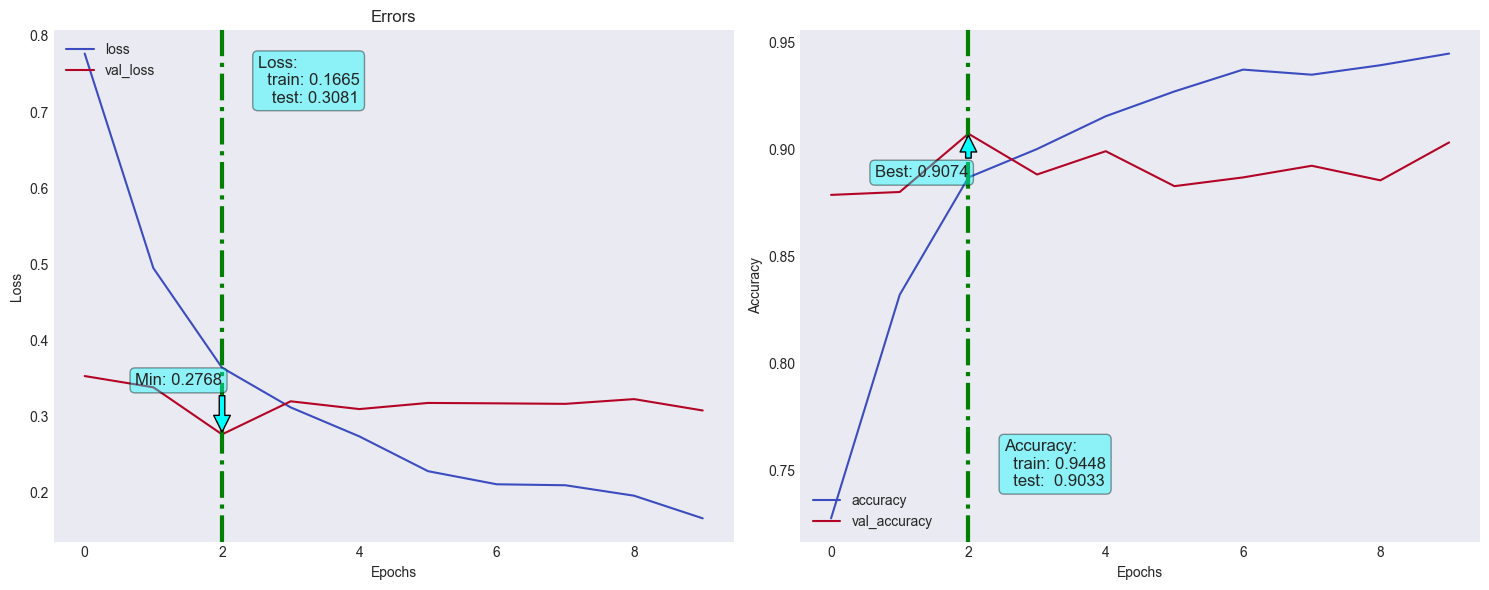

In [29]:
fn_plot_tf_hist(pd.DataFrame(history.history))

In [30]:
test_loss, test_acc = model.evaluate(test_ds, verbose=1)

92/92 [==============================] - 25s 270ms/step - loss: 0.3081 - accuracy: 0.9033


In [31]:
test_loss, test_acc

(0.30812084674835205, 0.9032697677612305)

In [32]:
y_test = np.concatenate((y for x,y in test_ds),axis = 0).squeeze()
y_pred = model.predict(test_ds)
y_pred = y_pred.argmax(axis=1)
print("Test accuracy : ", accuracy_score(y_test,y_pred))

TypeError: The first input argument needs to be a sequence

In [ ]:
valDir = 'valid_flowers'
inDir = os.path.join(inpDir,valDir)
valid_ds =tf.keras.preprocessing.image_dataset_from_directory(
    inDir, 
    validation_split=None,
    seed=RANDOM_STATE,
    image_size=[IMG_HEIGHT, IMG_WIDTH], ## @@@ WHAT!
    batch_size=BATCH_SIZE
)

In [ ]:
val_loss, val_acc = model.evaluate(valid_ds, verbose=1)
val_loss, val_acc

In [ ]:
y_valid = np.concatenate((y for x,y in valid_ds),axis = 0).squeeze()
y_valid_pred = model.predict(valid_ds)
y_valid_pred = y_valid_pred.argmax(axis=1)
print("Test accuracy : ", accuracy_score(y_valid,y_valid_pred))